In [7]:
# %%
# Creación del vector de fechas
fechas = [
    "{:4d}{:02d}".format(year, month)
    for year in range(1995, 2022)
    for month in range(1, 13)
]
fechas = [fecha for fecha in fechas if fecha >= "199507" and fecha <= "202104"]
fechas[0], fechas[-1], len(fechas)

('199507', '202104', 310)

In [8]:
# %%
# Lectura de los archivos
import pandas as pd

url = (
    "https://raw.githubusercontent.com/"
    "jdvelasq/datalabs/master/datasets/precio_bolsa_nacional/csv/{}.csv"
)

org_df = pd.concat([pd.read_csv(url.format(fecha)) for fecha in fechas])
# org_df.head()

HTTPError: HTTP Error 429: Too Many Requests

In [9]:
import pandas as pd
import requests

url_base = (
    "https://raw.githubusercontent.com/"
    "jdvelasq/datalabs/master/datasets/precio_bolsa_nacional/csv/{}.csv"
)

dataframes = []
errores = []

for fecha in fechas:
    url = url_base.format(fecha)
    response = requests.head(url)

    if response.status_code == 200:
        try:
            df = pd.read_csv(url)
            dataframes.append(df)
        except Exception as e:
            errores.append((fecha, str(e)))
    else:
        errores.append((fecha, f"HTTP {response.status_code}"))

org_df = pd.concat(dataframes, ignore_index=True)


In [10]:
melted_df = pd.melt(
    org_df,
    id_vars="Fecha",
    var_name="Hora",
    value_name="Precio",
)
melted_df = melted_df.sort_values(["Fecha", "Hora"]).reset_index(drop=True)
melted_df.head()

,Fecha,Hora,Precio
0,1995-07-21,0,1.073
1,1995-07-21,1,1.0
2,1995-07-21,10,6.0
3,1995-07-21,11,9.256
4,1995-07-21,12,9.256


In [11]:
melted_df.dtypes

Fecha     object
Hora      object
Precio    object
dtype: object

In [12]:
melted_df.Precio.isna().sum()

np.int64(21)

In [13]:
# Tamaño original del dataframe
melted_df.shape

(203736, 3)

In [14]:
# Eliminación de NA y tamaño final del dataframe
melted_df = melted_df.dropna()
melted_df.shape

(203715, 3)

In [15]:
# Búsqueda de registros con str en los precios
melted_df[melted_df["Precio"].map(lambda x: isinstance(x, str))].sort_values("Precio")

,Fecha,Hora,Precio
154535,2015-09-25,9,"1.004,81"
154522,2015-09-25,18,"1.004,81"
154566,2015-09-27,14,"1.014,81"
154562,2015-09-27,10,"1.014,81"
154570,2015-09-27,18,"1.014,81"
...,...,...,...
155012,2015-10-15,6,"990,52"
155013,2015-10-15,7,"990,52"
154961,2015-10-13,3,"990,52"
154962,2015-10-13,4,"990,52"


In [16]:
# %%
# Se elimina el '.' de los miles
melted_df["Precio"] = melted_df["Precio"].map(
    lambda x: x.replace(".", "") if isinstance(x, str) else x
)

# Se reemplaza la ',' por '.'
melted_df["Precio"] = melted_df["Precio"].map(
    lambda x: float(x.replace(",", ".")) if isinstance(x, str) else x
)

# Vefificación
melted_df["Precio"][melted_df["Precio"].map(lambda x: isinstance(x, str))].sort_values()

Series([], Name: Precio, dtype: float64)

In [17]:
# %%
# Revisión de los tipos de datos
melted_df.dtypes

Fecha      object
Hora       object
Precio    float64
dtype: object

In [18]:
# %%
# Cálculo de los precios diarios y renombramiento de la columna
precios_df = melted_df.groupby(["Fecha"]).agg({"Precio": "mean"})
precios_df = precios_df.rename(columns={"Precio": "Precio diario"})
precios_df.head()

,Precio diario
Fecha,
1995-07-21,4.924333
1995-07-22,1.269500
1995-07-23,0.953083
1995-07-24,4.305917
1995-07-25,1.149167


In [19]:
# Tranformación del indice a tipo fecha
precios_df.index = pd.to_datetime(precios_df.index)

# Cálculo del precio promedio por mes
precios_df["Precio mensual"] = precios_df.groupby(
    [precios_df.index.year, precios_df.index.month]
)["Precio diario"].transform("mean")

precios_df.head()

,Precio diario,Precio mensual
Fecha,,
1995-07-21,4.924333,1.552087
1995-07-22,1.269500,1.552087
1995-07-23,0.953083,1.552087
1995-07-24,4.305917,1.552087
1995-07-25,1.149167,1.552087


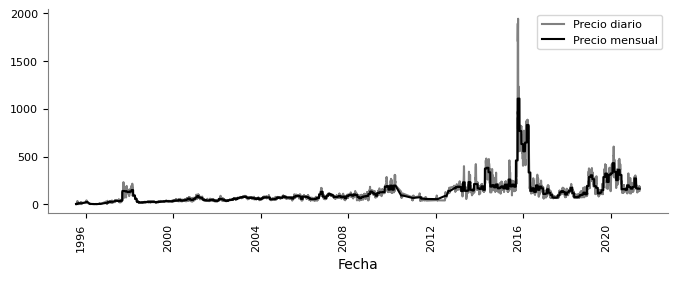

In [20]:
# %%
import os
import matplotlib.pyplot as plt

precios_df.plot(style=["gray", "k"], figsize=(8, 3))
plt.xticks(rotation="vertical", fontsize=8)
plt.yticks(fontsize=8)
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(fontsize=8)

if os.path.exists("../files/images") is False:
    os.makedirs("../files/images")

plt.savefig("../files/images/precios.png", bbox_inches="tight")

plt.show()